In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#Funciones de Python creadas por equipo Simulacion
from funcioneschicuadrado_continuas import*
from funciones_KS_test import*
from funciones_qq_pp_plotNuevas import*

In [3]:
datos_llegada_aviones=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosLlegadaAviones')
datos_llegada_aviones['Fecha de Llegada'] = pd.to_datetime(datos_llegada_aviones['Fecha de Llegada'])
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión
0,2023-05-01 00:00:00.000,Mediano
1,2023-05-01 00:12:48.533,Grande
2,2023-05-01 00:20:31.919,Mediano
3,2023-05-01 00:31:48.641,Pequeño
4,2023-05-01 00:40:09.796,Pequeño


In [4]:
datos_pasajeros=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosPasajeros')
datos_pasajeros.head()

,Pasajero,Tipo de pasaporte,¿Lleva maleta?
0,1,Extranjero,Sí
1,2,Nacional no biométrico,No
2,3,Nacional no biométrico,Sí
3,4,Nacional no biométrico,Sí
4,5,Nacional no biométrico,Sí


In [5]:
datos_tiempo_servicio=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='TiempoDeServicioBiométrico')
datos_tiempo_servicio.head()

,Persona atendida,Tipo de pasaporte,Tiempo de servicio (minutos)
0,1,Biométrico,0.349995
1,2,Biométrico,2.046627
2,3,Biométrico,0.232612
3,4,Biométrico,1.085411
4,5,Biométrico,2.585409


#### a.  Tiempo entre arribos de un avión desde un destino internacional para cada una de las siguientes franjas cuatro horarias: (6:00 am – 11:00 am; 11:00 am – 3:00 pm; 3:00 pm – 9:00 pm; 9:00 pm – 6:00 am) 

In [6]:
def asignar_franja(row):
    hora = row.hour
    if 6 <= hora < 11:
        return '6:00 am - 11:00 am'
    elif 11 <= hora < 15:
        return '11:00 am - 3:00 pm'
    elif 15 <= hora < 21:
        return '3:00 pm - 9:00 pm'
    else:
        return '9:00 pm - 6:00 am'

# Aplicar la función a la columna 'Fecha de Llegada'
datos_llegada_aviones['Franja Horaria'] = datos_llegada_aviones['Fecha de Llegada'].apply(asignar_franja)
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión,Franja Horaria
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am


Inicialmente asignamos una franja horaria para para los datos de llegada, para despues proceder a hacer un analisis de tiempo entre llegadas para cada franja horaria

In [7]:
franjas = ['6:00 am - 11:00 am', '11:00 am - 3:00 pm', '3:00 pm - 9:00 pm', '9:00 pm - 6:00 am']

datos_llegada_aviones = datos_llegada_aviones.sort_values('Fecha de Llegada')

datos_llegada_aviones['Fecha'] = datos_llegada_aviones['Fecha de Llegada'].dt.date

# Calcular el tiempo entre arribos
datos_llegada_aviones['Tiempo entre Arribos'] = datos_llegada_aviones['Fecha de Llegada']

# Filtrar datos para obtener tiempos entre arribos en cada franja horaria
datos_llegada_aviones['Tiempo entre Arribos (minutos)'] = datos_llegada_aviones['Fecha de Llegada'].diff().dt.total_seconds() / 60


datos_llegada_aviones.head(10)

,Fecha de Llegada,Tipo de Avión,Franja Horaria,Fecha,Tiempo entre Arribos,Tiempo entre Arribos (minutos)
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:00:00.000,NaN
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:12:48.533,12.808883
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:20:31.919,7.723100
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:31:48.641,11.278700
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:40:09.796,8.352583
5,2023-05-01 00:49:02.253,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:49:02.253,8.874283
6,2023-05-01 01:00:32.200,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:00:32.200,11.499117
7,2023-05-01 01:14:06.242,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:14:06.242,13.567367
8,2023-05-01 01:25:55.349,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:25:55.349,11.818450
9,2023-05-01 01:37:13.406,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:37:13.406,11.300950


In [8]:
tiempos_entre_arribos = []

# Obtener las fechas únicas del dataset
fechas_unicas = datos_llegada_aviones['Fecha'].unique()

# Definir las franjas horarias de interés
franjas = ['6:00 am - 11:00 am', '11:00 am - 3:00 pm', '3:00 pm - 9:00 pm', '9:00 pm - 6:00 am']

# Iterar por cada fecha
for fecha in fechas_unicas:
    # Filtrar los datos por la fecha actual
    datos_dia = datos_llegada_aviones[datos_llegada_aviones['Fecha'] == fecha]
    
    # Ordenar los datos por la hora de llegada
    datos_dia = datos_dia.sort_values('Fecha de Llegada')
    
    # Calcular el tiempo entre arribos
    tiempos_franja = datos_dia['Fecha de Llegada'].diff().dt.total_seconds() / 60
    
    # Añadir los tiempos entre arribos al DataFrame
    datos_dia['Tiempo entre Arribos (minutos)'] = tiempos_franja
    
    # Añadir los datos al array principal
    tiempos_entre_arribos.extend(datos_dia.to_dict('records'))

# Convertir el array a un DataFrame para mejor visualización
tiempos_entre_arribos_df = pd.DataFrame(tiempos_entre_arribos)

# Identificar cambios de franja horaria y marcar la primera fila después de cada cambio
tiempos_entre_arribos_df['Cambio de Franja'] = (tiempos_entre_arribos_df['Franja Horaria'] != 
                                                tiempos_entre_arribos_df['Franja Horaria'].shift(1))

# Crear una columna para indicar si una fila debe ser eliminada
tiempos_entre_arribos_df['Eliminar'] = (tiempos_entre_arribos_df['Cambio de Franja'] & 
                                        tiempos_entre_arribos_df['Tiempo entre Arribos (minutos)'].notna())

# Filtrar las filas que no deben ser eliminadas
tiempos_entre_arribos_df = tiempos_entre_arribos_df[~tiempos_entre_arribos_df['Eliminar']]

# Eliminar las columnas auxiliares
tiempos_entre_arribos_df = tiempos_entre_arribos_df.drop(columns=['Cambio de Franja', 'Eliminar'])

# Mostrar los primeros resultados
tiempos_entre_arribos_df.head(10)

,Fecha de Llegada,Tipo de Avión,Franja Horaria,Fecha,Tiempo entre Arribos,Tiempo entre Arribos (minutos)
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:00:00.000,NaN
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:12:48.533,12.808883
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:20:31.919,7.723100
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:31:48.641,11.278700
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:40:09.796,8.352583
5,2023-05-01 00:49:02.253,Pequeño,9:00 pm - 6:00 am,2023-05-01,2023-05-01 00:49:02.253,8.874283
6,2023-05-01 01:00:32.200,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:00:32.200,11.499117
7,2023-05-01 01:14:06.242,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:14:06.242,13.567367
8,2023-05-01 01:25:55.349,Grande,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:25:55.349,11.818450
9,2023-05-01 01:37:13.406,Mediano,9:00 pm - 6:00 am,2023-05-01,2023-05-01 01:37:13.406,11.300950


In [9]:
promedio_tiempo_entre_arribos = tiempos_entre_arribos_df.groupby('Franja Horaria')['Tiempo entre Arribos (minutos)'].mean().reset_index()
print('Tiempo entre arribos promedio por franja horaria:\n')
print(promedio_tiempo_entre_arribos)

Tiempo entre arribos promedio por franja horaria:

       Franja Horaria  Tiempo entre Arribos (minutos)
0  11:00 am - 3:00 pm                        3.691804
1   3:00 pm - 9:00 pm                        7.016715
2  6:00 am - 11:00 am                        5.948389
3   9:00 pm - 6:00 am                       10.908736


In [10]:
datos_llegada_aviones['Franja Horaria'].value_counts()

Franja Horaria
11:00 am - 3:00 pm    1289
6:00 am - 11:00 am    1046
3:00 pm - 9:00 pm     1021
9:00 pm - 6:00 am     1018
Name: count, dtype: int64

In [11]:
tiempos_entre_arribos_df['Franja Horaria'].value_counts()

Franja Horaria
11:00 am - 3:00 pm    1268
6:00 am - 11:00 am    1025
3:00 pm - 9:00 pm     1001
9:00 pm - 6:00 am      998
Name: count, dtype: int64

In [12]:
print('Datos perdidos en tiempo entre arribos\n')
print(datos_llegada_aviones['Franja Horaria'].value_counts()-tiempos_entre_arribos_df['Franja Horaria'].value_counts())

Datos perdidos en tiempo entre arribos

Franja Horaria
11:00 am - 3:00 pm    21
6:00 am - 11:00 am    21
3:00 pm - 9:00 pm     20
9:00 pm - 6:00 am     20
Name: count, dtype: int64


Vemos entonces que la llegada de aviones esta distribuida de manera equitativa en todas las franjas excepto de 11 AM a 3 PM donde se tienen 200 llegadas mas, con un tiempo entre arribos menor. 


| Franja Horaria      | Tiempo entre Arribos (minutos) |
|--------------------|--------------------------------|
| 11:00 am - 3:00 pm | 3.691804                       |
| 3:00 pm - 9:00 pm  | 7.016715                       |
| 6:00 am - 11:00 am | 5.948389                       |
| 9:00 pm - 6:00 am  | 10.908736                      |


Datos originales
| Franja Horaria      | Conteo de llegada |
|--------------------|-------------------|
| 11:00 am - 3:00 pm | 1289              |
| 6:00 am - 11:00 am | 1046              |
| 3:00 pm - 9:00 pm  | 1021              |
| 9:00 pm - 6:00 am  | 1018              |

Datos tiempo entre arribos
| Franja Horaria      | Conteo de llegada |
|--------------------|-------------------|
| 11:00 am - 3:00 pm | 1268              |
| 6:00 am - 11:00 am | 1025              |
| 3:00 pm - 9:00 pm  | 1001              |
| 9:00 pm - 6:00 am  | 998              |

Datos perdidos en tiempo entre arribos
| Franja Horaria      | Conteo de llegada |
|--------------------|-------------------|
| 11:00 am - 3:00 pm | 21             |
| 6:00 am - 11:00 am | 21              |
| 3:00 pm - 9:00 pm  | 20              |
| 9:00 pm - 6:00 am  | 20              |

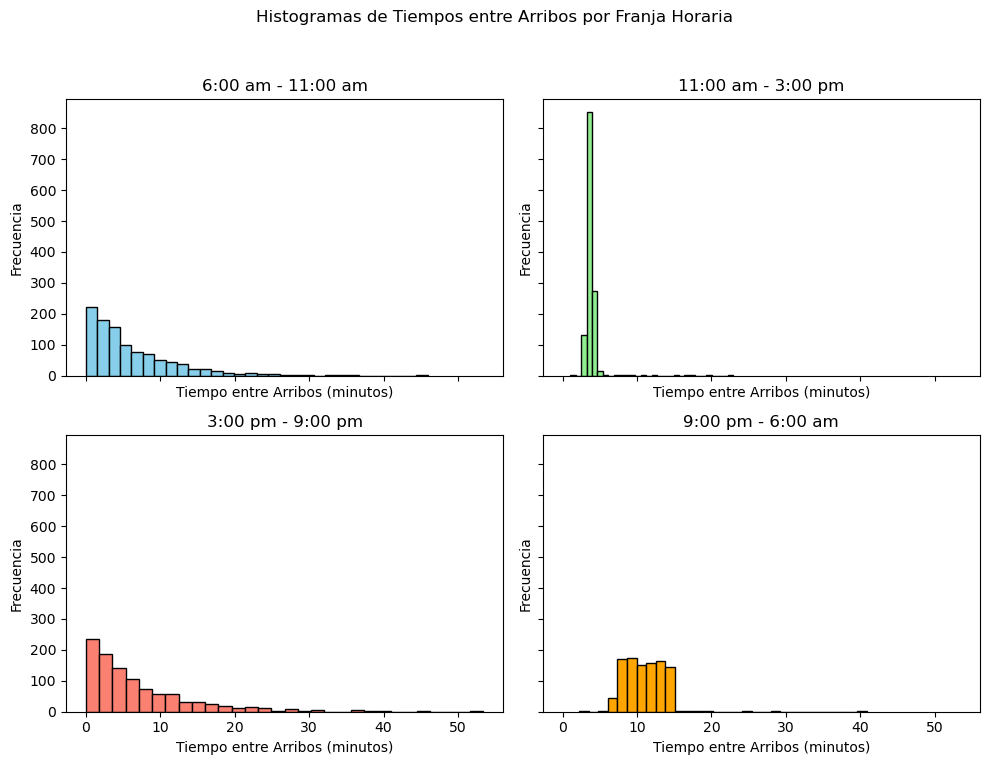

In [18]:
colores = ['skyblue', 'lightgreen', 'salmon', 'orange']  # Colores para cada franja horaria


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
fig.suptitle('Histogramas de Tiempos entre Arribos por Franja Horaria')

# Crear histogramas para cada franja horaria
for ax, franja,color in zip(axs.flatten(), franjas,colores):
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]['Tiempo entre Arribos (minutos)'].dropna()
    ax.hist(datos_franja, bins=30, edgecolor='black',color=color)
    ax.set_title(franja)
    ax.set_xlabel('Tiempo entre Arribos (minutos)')
    ax.set_ylabel('Frecuencia')


# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar los histogramas
plt.show()

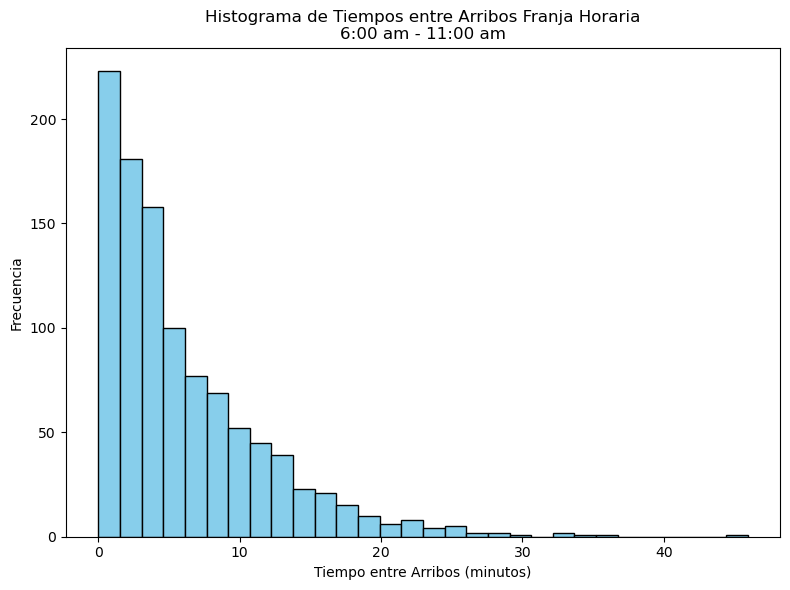

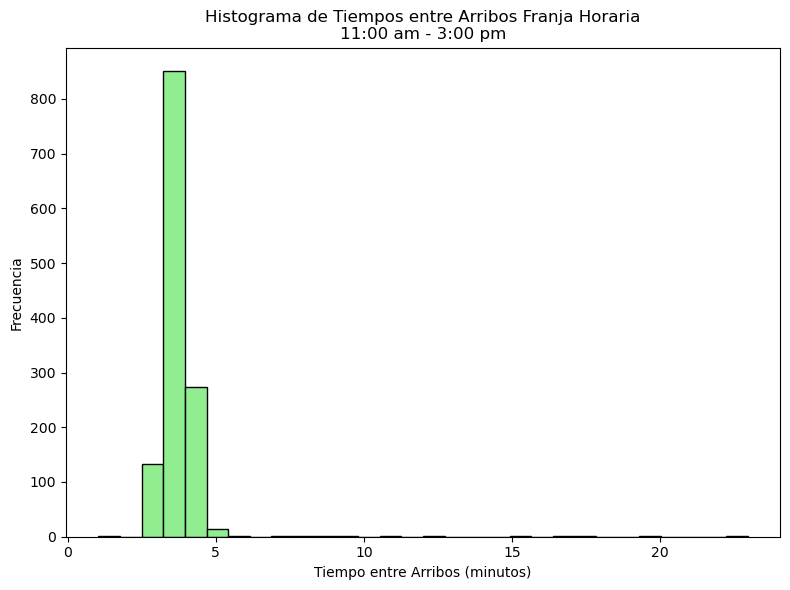

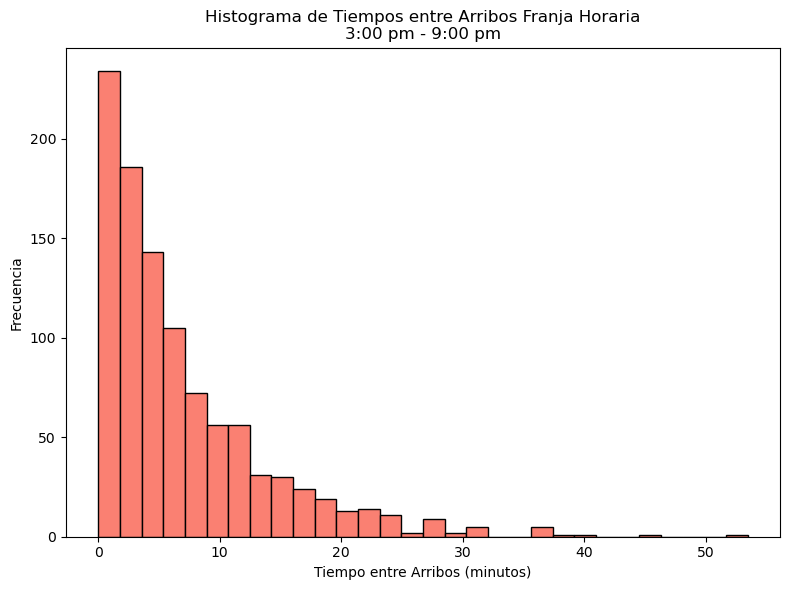

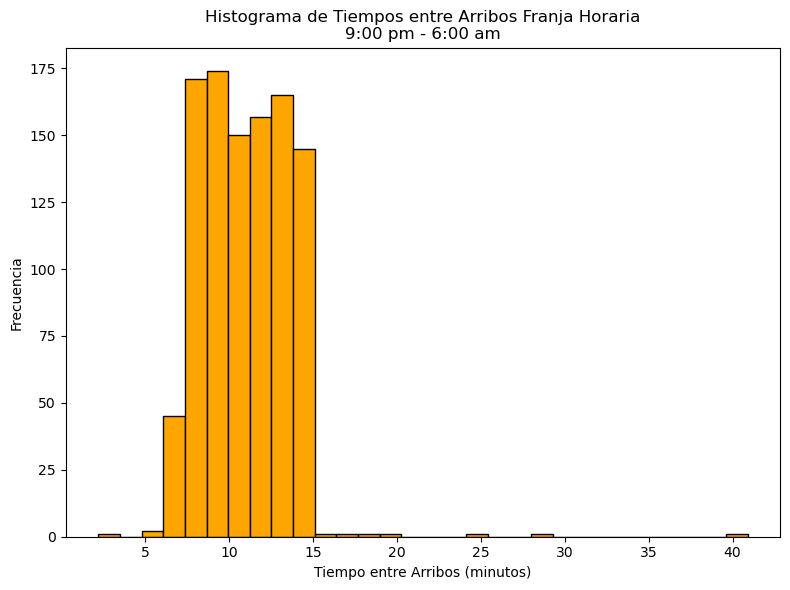

In [23]:

colores = ['skyblue', 'lightgreen', 'salmon', 'orange']  # Colores para cada franja horaria

for franja, color in zip(franjas, colores):
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]['Tiempo entre Arribos (minutos)'].dropna()
    
    plt.figure(figsize=(8, 6))
    plt.hist(datos_franja, bins=30, edgecolor='black', color=color)  # Asignar el color correspondiente
    plt.title(f'Histograma de Tiempos entre Arribos Franja Horaria\n{franja}')
    plt.xlabel('Tiempo entre Arribos (minutos)')
    plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

A simple vista se puede ver que de 6 am - 11am, 3 pm - 9 pm se ven exponenciales, 11 am - 3 pm se ve normal o log normal y 9 pm - 6 am se ve uniforme, faltaria revisar esto con pruebas de bondad de ajuste 

Primero se separan las franjas horarias usando pd.to_datetime para manejar fechas y horas, y se separan las 4 franjas mencionadas. Posterior a esto se calcula el tiempo entre arribos calculado en minutos (este puede ser convertido a cualquier tipo de unidad de tiempo mas adelante)

In [18]:
def aplicar_pruebas_bondad_ajuste(data):
    print("\nEvaluando bondad de ajuste para distribución Normal:")
    chi_square_normal_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Exponencial:")
    chi_square_exponential_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Lognormal:")
    chi_square_lognormal_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Uniforme:")
    chi_square_uniform_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Triangular:")
    chi_square_triangular_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Gamma:")
    chi_square_gamma_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Weibull:")
    chi_square_weibull_goodness_of_fit(data)


In [20]:
for franja in franjas:
    print(f"\n--- Análisis para la franja horaria: {franja} ---")
    datos_franja = tiempos_entre_arribos_df[tiempos_entre_arribos_df['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    aplicar_pruebas_bondad_ajuste(tiempos_entre_arribos)



--- Análisis para la franja horaria: 6:00 am - 11:00 am ---

Evaluando bondad de ajuste para distribución Normal:
Parámetro estimado: Media = 5.948389414634146
Parámetro estimado: Desviación Estándar = 5.820938093493373
Chi-squared statistic: 857.2000000000027
p-value: 0.0

Evaluando bondad de ajuste para distribución Exponencial:
Parámetro estimado: Tasa = 0.16811273275751143
Chi-squared statistic: 169.59999999999903
p-value: 0.9577199926644187

Evaluando bondad de ajuste para distribución Lognormal:
Parámetro estimado (lognormal asociada): Media = 1.2281822014925585
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2498301729549852
Chi-squared statistic: 363.6000000000012
p-value: 2.3733348619714434e-11

Evaluando bondad de ajuste para distribución Uniforme:
Parámetro estimado: a = 0.0035499999999999998
Parámetro estimado: b = 45.93255
Chi-squared statistic: 3077.2
p-value: 0.0

Evaluando bondad de ajuste para distribución Triangular:
Parámetro estimado: a = 0.0035499

Despues de revisar las distribuciones, fue posible ver con una prueba chi cuadrado las distribuciones con un P-value mayor a una significancia del 5%:


| Franja Horaria      | Distribucion  |
|--------------------|-------------------|
| 6:00 am - 11:00 am| Exponencial P-value:  0.957          |
| 11:00 am - 3:00 pm | Lognormal P-value:    0.636          |
| 3:00 pm - 9:00 pm  | Exponencial  P-value:  0.860         |
| 9:00 pm - 6:00 am  | Uniforme  P-value:   0.398         |

Se observa entonces las distribuciones a las que pertenecerian cada franja horaria por su distribucion de tiempo entre llegadas, gracias a pruebas de bondad de ajuste con chicuadrado. (En anexos se pueden ver los qq & pp plot donde parecia haber cercania con una distribucion lognormal, sin embargo no pudo ser comprobado con Chicuadrado)

In [21]:
estadisticas_franja = tiempos_entre_arribos_df.groupby('Franja Horaria')['Tiempo entre Arribos (minutos)'].agg(['mean', 'std']).reset_index()

# Renombrar las columnas para mayor claridad
estadisticas_franja.columns = ['Franja Horaria', 'Media (minutos)', 'Desviación Estándar (minutos)']

# Mostrar los resultados
print(estadisticas_franja)


       Franja Horaria  Media (minutos)  Desviación Estándar (minutos)
0  11:00 am - 3:00 pm         3.691804                       0.382304
1   3:00 pm - 9:00 pm         7.016715                       7.133663
2  6:00 am - 11:00 am         5.948389                       5.823780
3   9:00 pm - 6:00 am        10.908736                       2.310568


#### b. Tiempo de atención del módulo biométrico inteligente. (30 puntos)

In [15]:
media_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].mean()
mediana_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].median()
desviacion_estandar = datos_tiempo_servicio['Tiempo de servicio (minutos)'].std()
rango_intercuartilico = datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.75) - datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.25)

print(f"Media: {media_tiempo:.2f} minutos")
print(f"Mediana: {mediana_tiempo:.2f} minutos")
print(f"Desviación Estándar: {desviacion_estandar:.2f} minutos")
print(f"Rango Intercuartílico: {rango_intercuartilico:.2f} minutos")

Media: 1.34 minutos
Mediana: 0.92 minutos
Desviación Estándar: 1.33 minutos
Rango Intercuartílico: 1.48 minutos


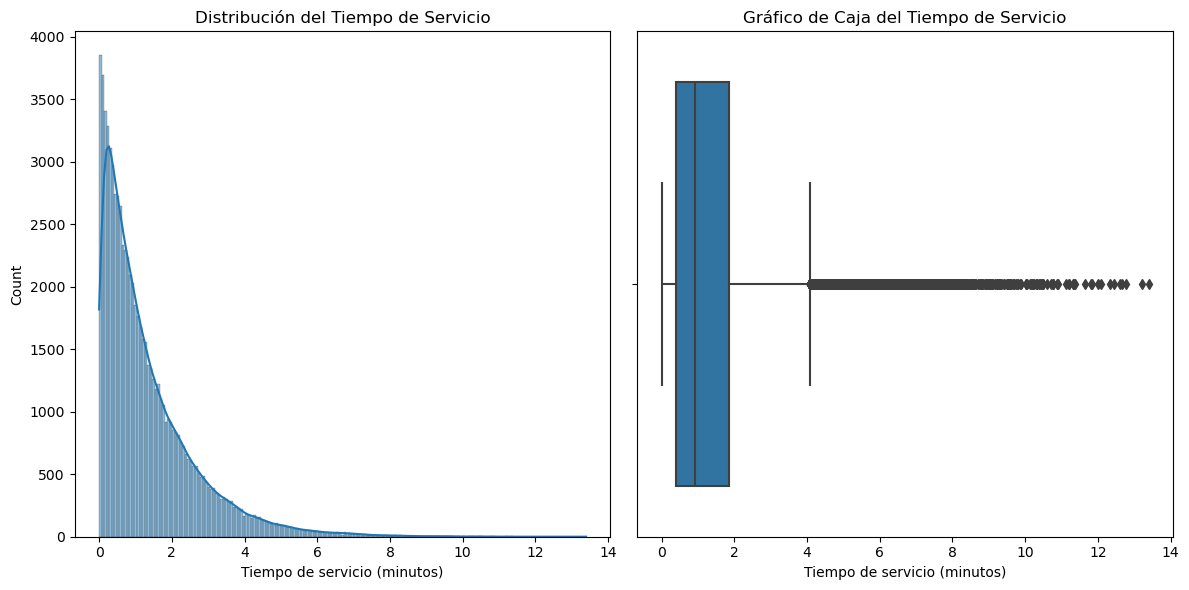

In [16]:
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(datos_tiempo_servicio['Tiempo de servicio (minutos)'], kde=True)
plt.title('Distribución del Tiempo de Servicio')

# Gráfico de Caja
plt.subplot(1, 2, 2)
sns.boxplot(x=datos_tiempo_servicio['Tiempo de servicio (minutos)'])
plt.title('Gráfico de Caja del Tiempo de Servicio')

plt.tight_layout()
plt.show()

In [27]:
aplicar_pruebas_bondad_ajuste(datos_tiempo_servicio['Tiempo de servicio (minutos)'])


Evaluando bondad de ajuste para distribución Normal:
Parámetro estimado: Media = 1.3350003637764654
Parámetro estimado: Desviación Estándar = 1.329438449470138
Chi-squared statistic: 75555.87492617394
p-value: 0.0

Evaluando bondad de ajuste para distribución Exponencial:
Parámetro estimado: Tasa = 0.7490634662983819
Chi-squared statistic: 15398.19341757482
p-value: 0.1792451945711111

Evaluando bondad de ajuste para distribución Lognormal:
Parámetro estimado (lognormal asociada): Media = -0.28596756733168804
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2803043893885682
Chi-squared statistic: 46497.16928467144
p-value: 0.0

Evaluando bondad de ajuste para distribución Uniforme:
Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463
Chi-squared statistic: 320906.36545804405
p-value: 0.0

Evaluando bondad de ajuste para distribución Triangular:
Parámetro estimado: a = 2.645160719497484e-06
Parámetro estimado: b = 13.396195505872463
P

c:\Users\WD\.ipython\Workspace Visual Code\Maestria\Mastertrack 3\Simulacion-Python\Semana 3\Caso\funcioneschicuadrado_continuas.py:350: RuntimeWarning: invalid value encountered in scalar divide
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2 / expected_frequencies[i] for i in range(k-1))


Chi-squared statistic: nan
p-value: nan

Evaluando bondad de ajuste para distribución Weibull:
Parámetro estimado: Escala = 1.3365523718394834
Parámetro estimado: Forma = 1.0027390493416182
Chi-squared statistic: 16116.963196923873
p-value: 3.697171411243261e-07


In [28]:
KS_test_exponential(datos_tiempo_servicio['Tiempo de servicio (minutos)'],tasa=0.7490634662983819)

Kolmogorov Smirnov statistic: 0.002552590343475658
p-value: 0.7024911927496299



|   Prueba Bondad de Ajuste para Tiempo de Servicio  | Distribucion - P-Value  |
|--------------------|-------------------|
| Chicuadrado| Exponencial P-value:  0.1792          |
| Kolmogorov-Smirnov      |   Exponencial P-value: 0.7024911927496299                               |

#### c. Probabilidad de que el avión que acaba de aterrizar sea grande, mediano o pequeño. (10 puntos)

In [17]:
total_aviones = datos_llegada_aviones.shape[0]

conteo_por_tipo = datos_llegada_aviones['Tipo de Avión'].value_counts()

# Mostrar los conteos
print("Conteo por tipo de avión:")
print(conteo_por_tipo)

Conteo por tipo de avión:
Tipo de Avión
Mediano    2623
Grande     1314
Pequeño     437
Name: count, dtype: int64


In [18]:
probabilidades_tamano_avion = conteo_por_tipo / total_aviones

# Mostrar las probabilidades
print("\nProbabilidades de cada tipo de avión:")
print(probabilidades_tamano_avion)


Probabilidades de cada tipo de avión:
Tipo de Avión
Mediano    0.599680
Grande     0.300412
Pequeño    0.099909
Name: count, dtype: float64


#### d. Probabilidad asociada al tipo de pasajero/pasaporte. (10 puntos)

In [23]:
total_registros = datos_pasajeros.shape[0]

# Contar la cantidad de cada tipo de pasaporte
conteo_por_tipo = datos_pasajeros['Tipo de pasaporte'].value_counts()

print("Conteo por tipo de pasaporte:")
print(conteo_por_tipo)

Conteo por tipo de pasaporte:
Tipo de pasaporte
Extranjero                279638
Nacional no biométrico    151689
Nacional biométrico        76203
Name: count, dtype: int64


In [24]:
probabilidades_tipo_pasajero = conteo_por_tipo / total_registros

# Mostrar las probabilidades
print("\nProbabilidades asociadas a cada tipo de pasaporte:")
print(probabilidades_tipo_pasajero)


Probabilidades asociadas a cada tipo de pasaporte:
Tipo de pasaporte
Extranjero                0.550978
Nacional no biométrico    0.298877
Nacional biométrico       0.150145
Name: count, dtype: float64


#### e. Probabilidad de que el pasajero haya viajado con maleta. (10 puntos)

In [21]:
total_pasajeros = datos_pasajeros.shape[0]
conteo_con_maleta = datos_pasajeros['¿Lleva maleta?'].value_counts().get('Sí', 0)

# Mostrar los conteos
print(f"Total de pasajeros: {total_pasajeros}")
print(f"Pasajeros con maleta: {conteo_con_maleta}")

probabilidad_con_maleta = conteo_con_maleta / total_pasajeros

# Mostrar la probabilidad
print(f"Probabilidad de que un pasajero haya viajado con maleta: {probabilidad_con_maleta:.2f}")


Total de pasajeros: 507530
Pasajeros con maleta: 372153
Probabilidad de que un pasajero haya viajado con maleta: 0.73


### Anexos

##### A continuacion se grafican PP y QQ plots para el tiempo entre arribos

Despues de revisar las distribuciones, fue posible ver que estos datos para las franjas horarias parecen tener ciertas distribuciones aunque no es facil de ver:


| Franja Horaria      | Distribucion  |
|--------------------|-------------------|
| 6:00 am - 11:00 am| Tanto Exponencial como Weibull             |
| 11:00 am - 3:00 pm | La que mas se parece es Lognormal pero no es seguro            |
| 3:00 pm - 9:00 pm  | Exponencial y posiblemente Weibull             |
| 9:00 pm - 6:00 am  | La que mas se parece es Lognormal pero no es seguro              |

Esto no reemplaza unas pruebas de bondad de ajuste para comprobar todo de manera correcta


Análisis para la franja horaria EXPONENCIAL: 6:00 am - 11:00 am
Parámetro estimado: Tasa = 0.16811273275751143


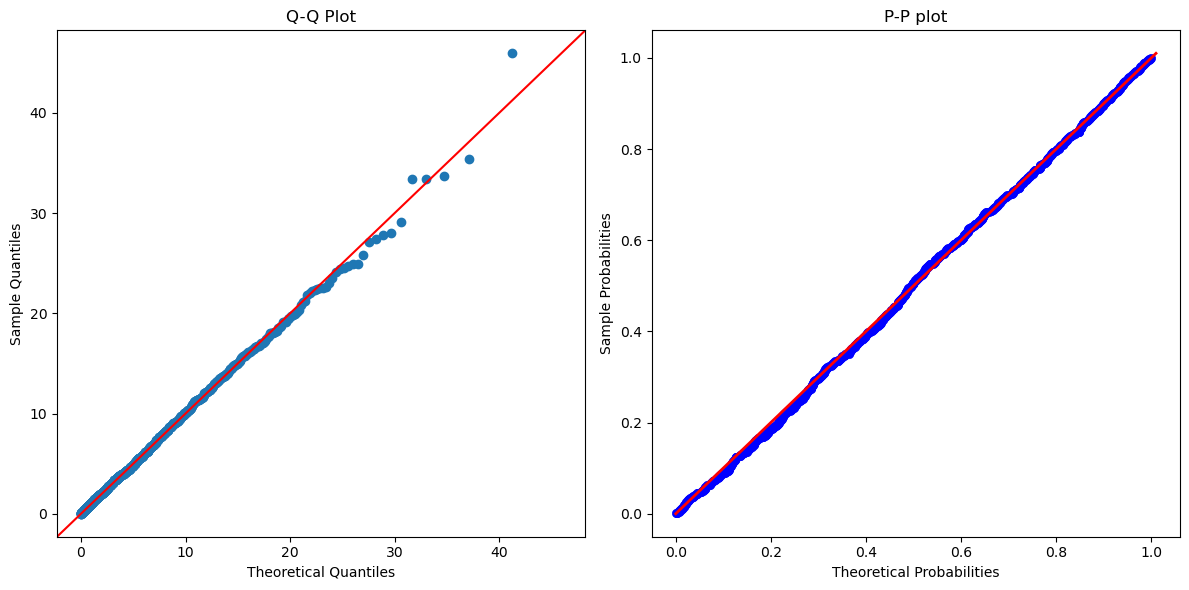

Análisis para la franja horaria EXPONENCIAL: 11:00 am - 3:00 pm
Parámetro estimado: Tasa = 0.2708702800413111


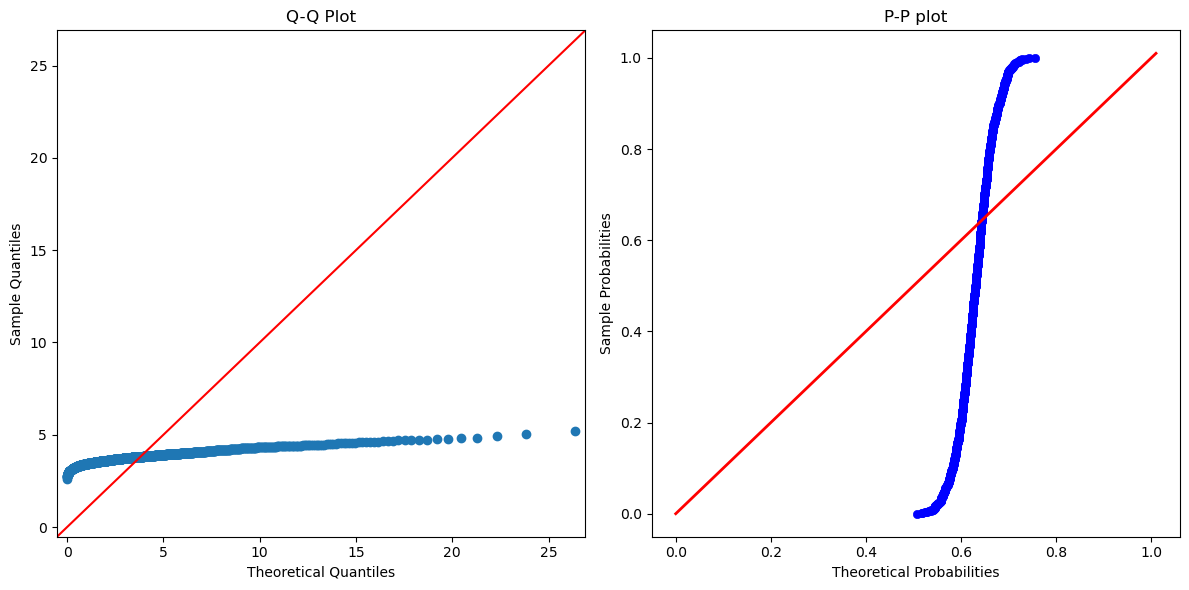

Análisis para la franja horaria EXPONENCIAL: 3:00 pm - 9:00 pm
Parámetro estimado: Tasa = 0.14251684008738735


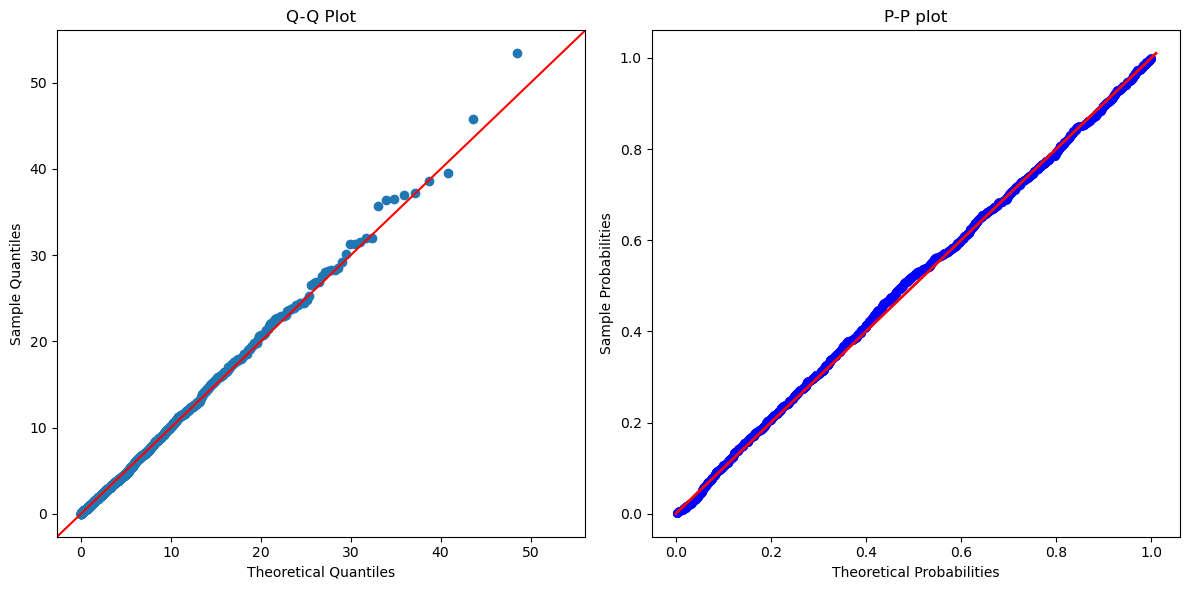

Análisis para la franja horaria EXPONENCIAL: 9:00 pm - 6:00 am
Parámetro estimado: Tasa = 0.09166964931849152


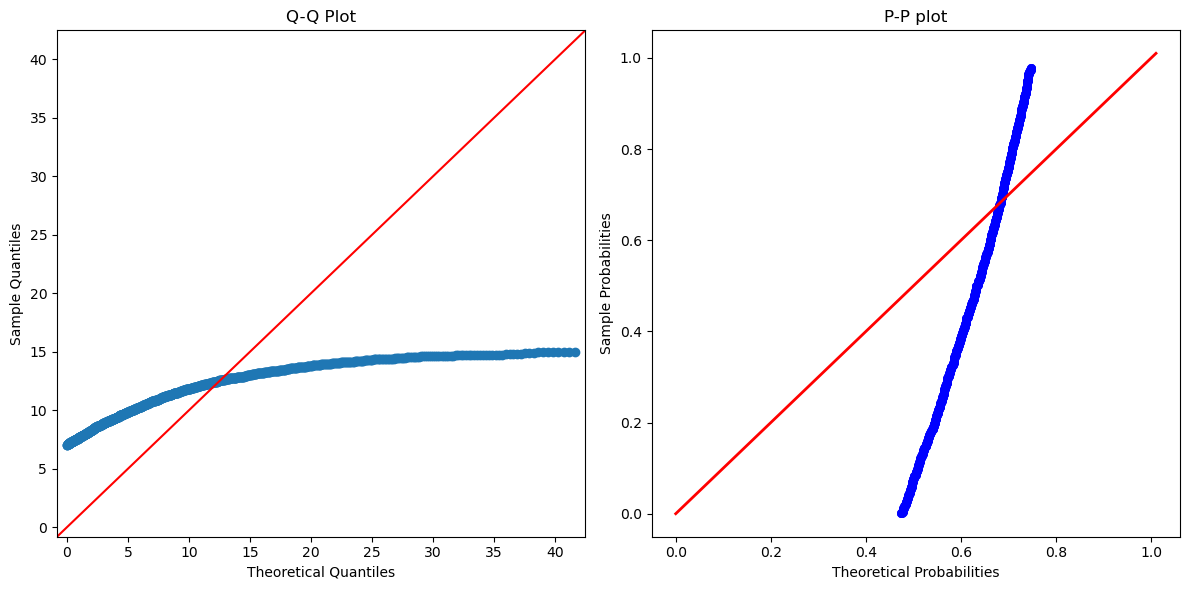

In [ ]:

for franja in franjas:
    print(f"Análisis para la franja horaria EXPONENCIAL: {franja}")
    datos_franja = tiempos_entre_arribos_df[tiempos_entre_arribos_df['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)']
    PP_QQ_plot_exponential(tiempos_entre_arribos)

Análisis para la franja horaria WEIBULL: 6:00 am - 11:00 am
Parámetro estimado: Forma = 1.0238005605107
Parámetro estimado: Escala = 6.0060899730649355


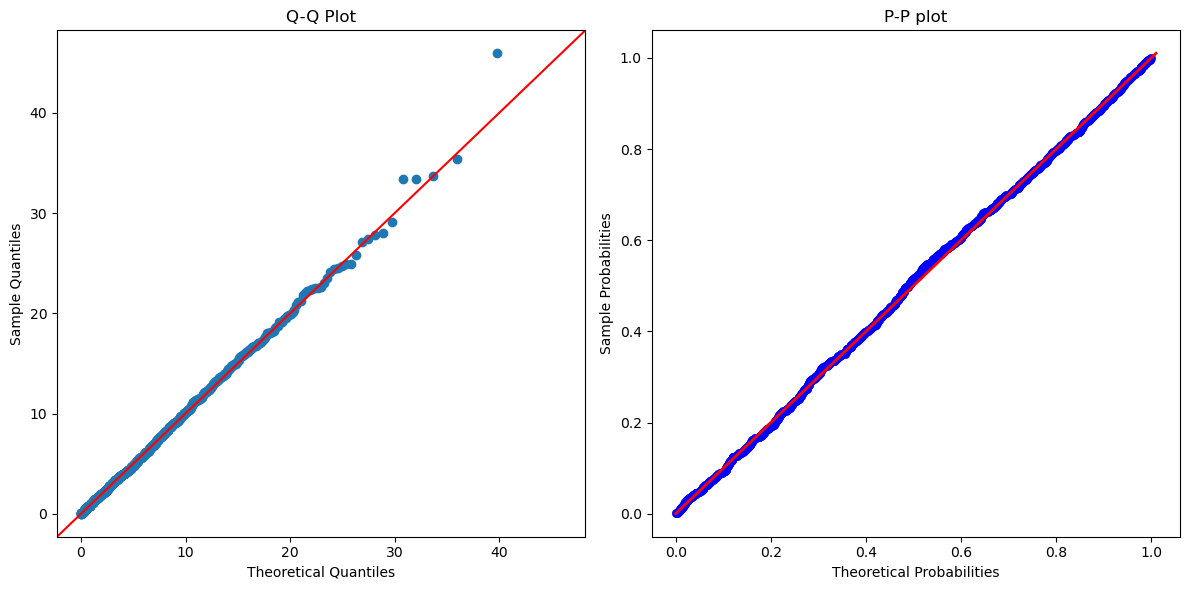

Análisis para la franja horaria WEIBULL: 11:00 am - 3:00 pm
Parámetro estimado: Forma = 11.741171270052494
Parámetro estimado: Escala = 3.8556705510380787


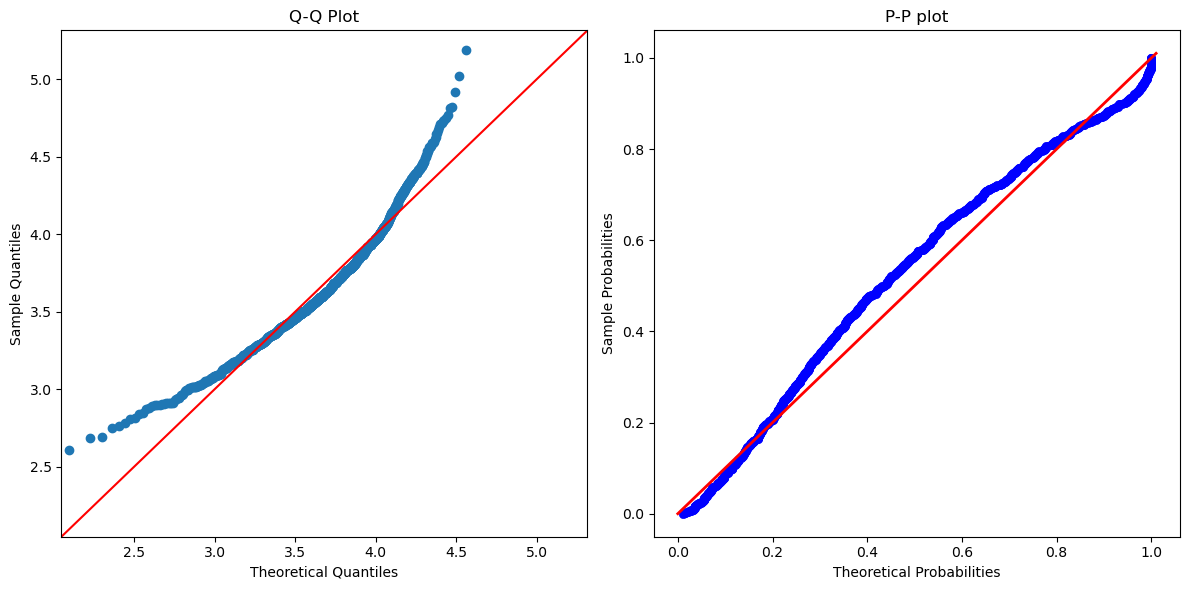

Análisis para la franja horaria WEIBULL: 3:00 pm - 9:00 pm
Parámetro estimado: Forma = 0.9827420948633471
Parámetro estimado: Escala = 6.964121891391093


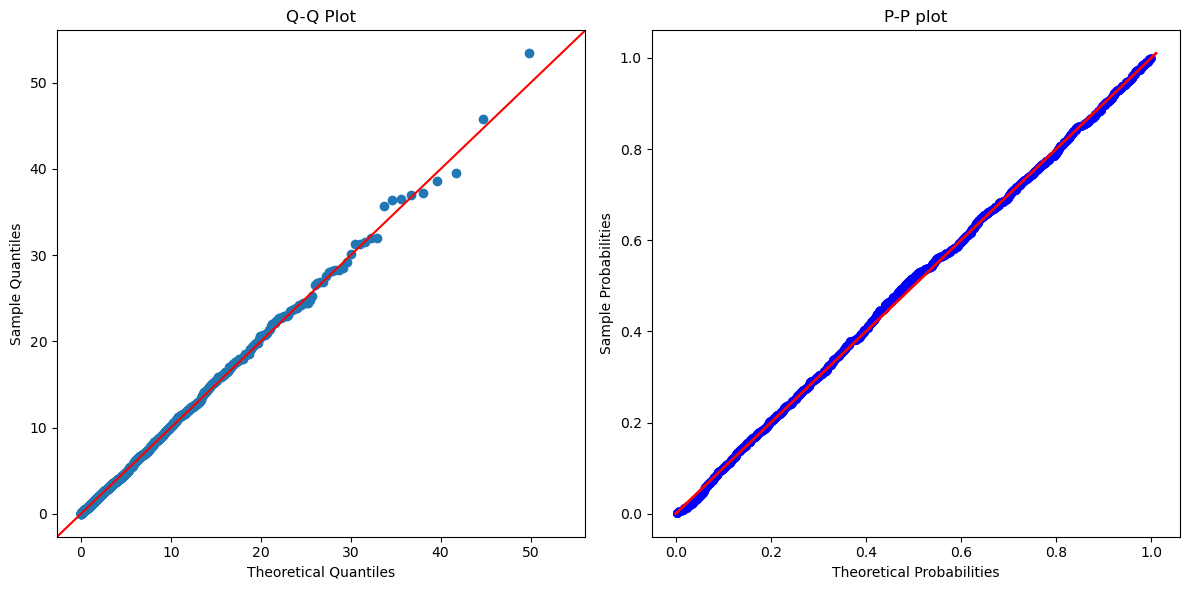

Análisis para la franja horaria WEIBULL: 9:00 pm - 6:00 am
Parámetro estimado: Forma = 5.398410280245084
Parámetro estimado: Escala = 11.828748173514152


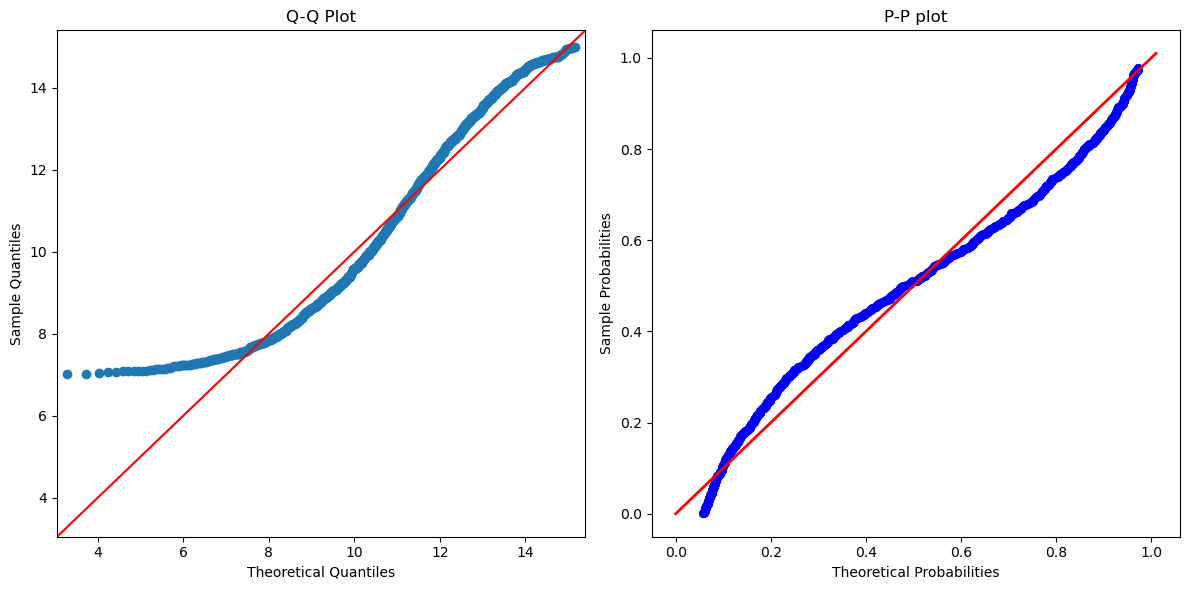

In [ ]:
for franja in franjas:
    print(f"Análisis para la franja horaria WEIBULL: {franja}")
    datos_franja = tiempos_entre_arribos_df[tiempos_entre_arribos_df['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)']
    PP_QQ_plot_weibull(tiempos_entre_arribos)

Análisis para la franja horaria LOGNORMAL: 6:00 am - 11:00 am
Parámetro estimado (normal asociada): Media = 1.2281822014925585
Parámetro estimado (normal asociada): Desviación Estándar = 1.2498301729549852


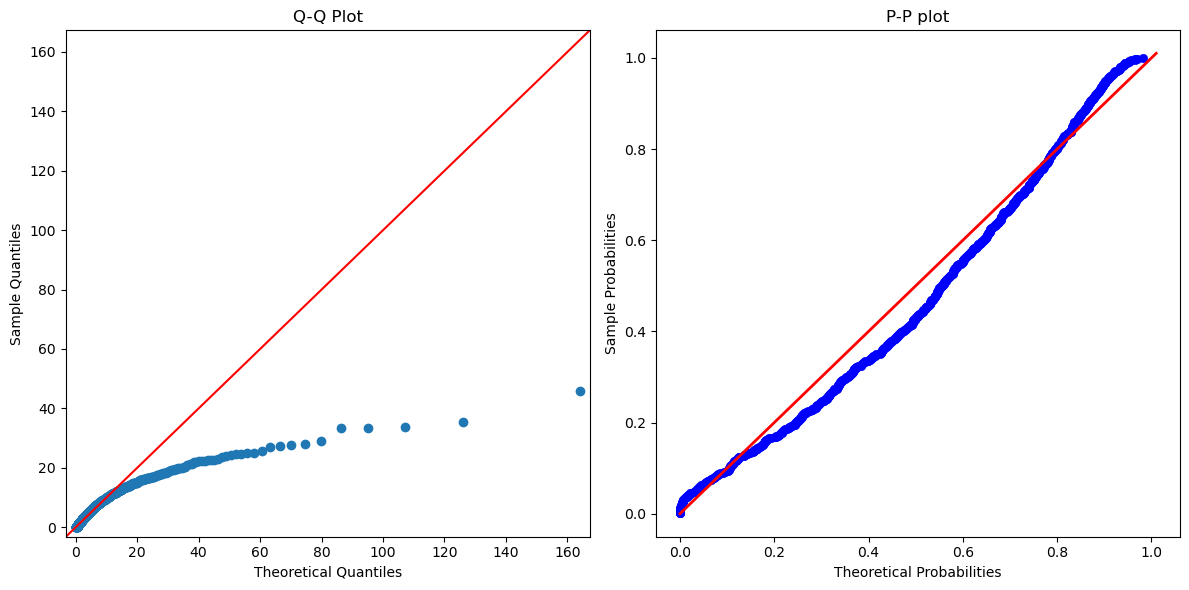

Análisis para la franja horaria LOGNORMAL: 11:00 am - 3:00 pm
Parámetro estimado (normal asociada): Media = 1.3007791717229005
Parámetro estimado (normal asociada): Desviación Estándar = 0.10334412225694578


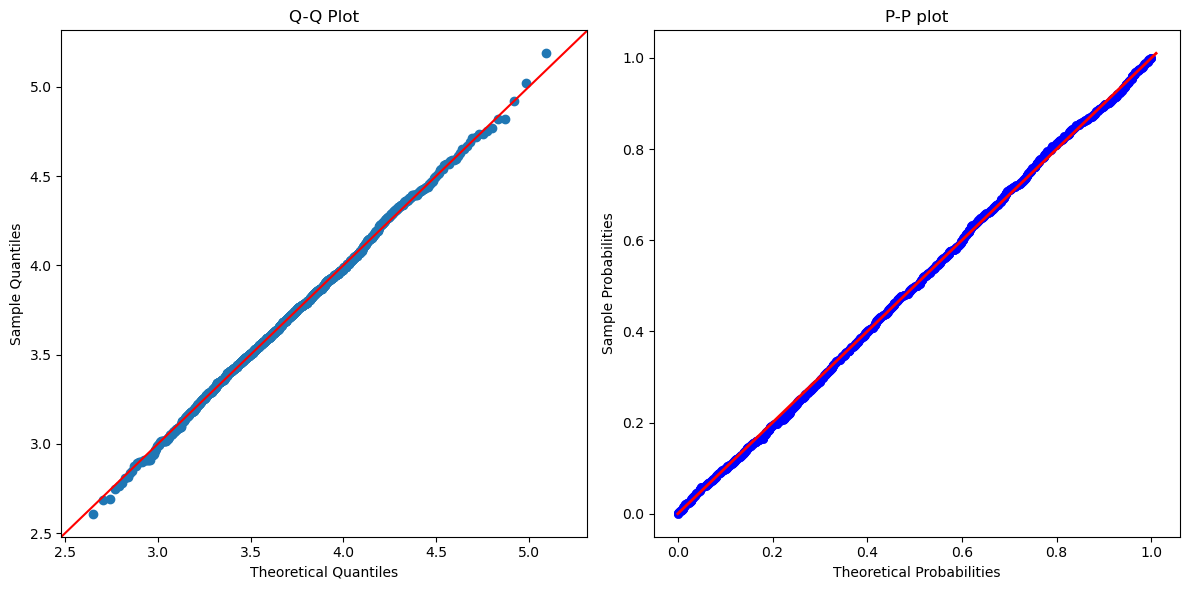

Análisis para la franja horaria LOGNORMAL: 3:00 pm - 9:00 pm
Parámetro estimado (normal asociada): Media = 1.3681853821510235
Parámetro estimado (normal asociada): Desviación Estándar = 1.2478932484049388


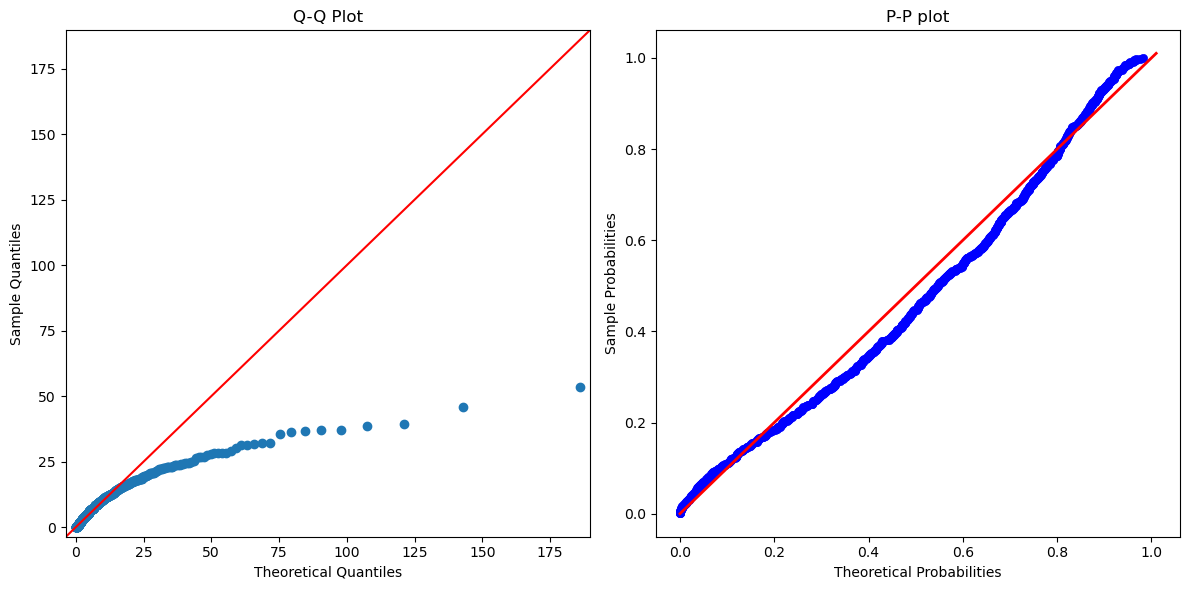

Análisis para la franja horaria LOGNORMAL: 9:00 pm - 6:00 am
Parámetro estimado (normal asociada): Media = 2.3663420288948895
Parámetro estimado (normal asociada): Desviación Estándar = 0.2176922391681197


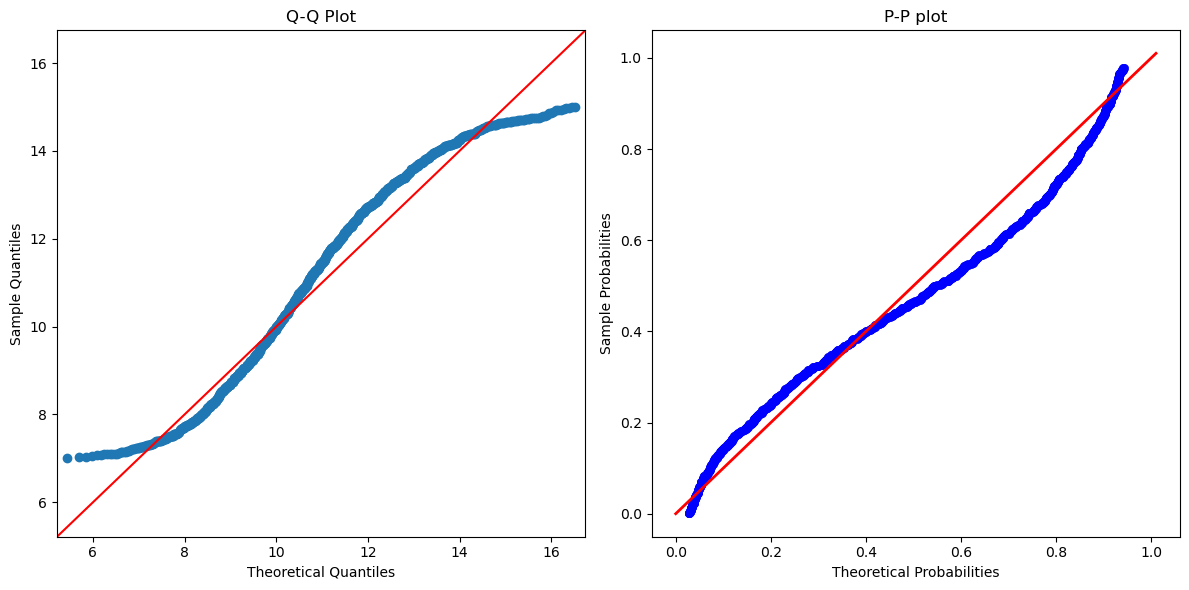

In [ ]:
for franja in franjas:
    print(f"Análisis para la franja horaria LOGNORMAL: {franja}")
    datos_franja = tiempos_entre_arribos_df[tiempos_entre_arribos_df['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)']
    PP_QQ_plot_lognormal(tiempos_entre_arribos)

Análisis para la franja horaria UNIFORME: 6:00 am - 11:00 am
Parámetro estimado: a = 0.0035499999999999998
Parámetro estimado: b = 45.93255


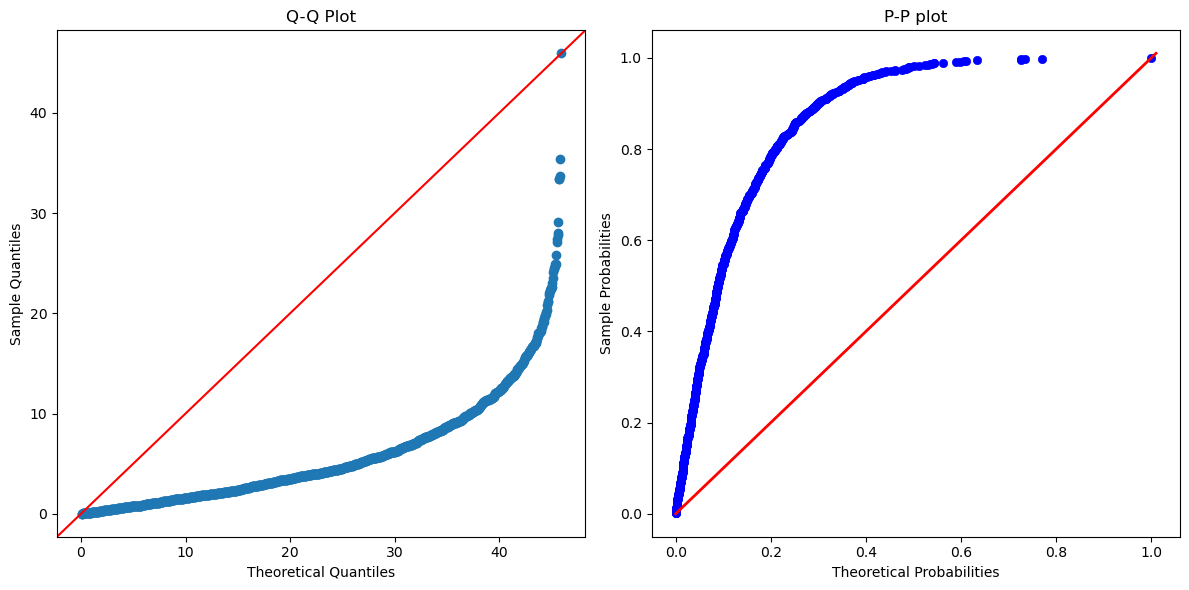

Análisis para la franja horaria UNIFORME: 11:00 am - 3:00 pm
Parámetro estimado: a = 2.60935
Parámetro estimado: b = 5.1869499999999995


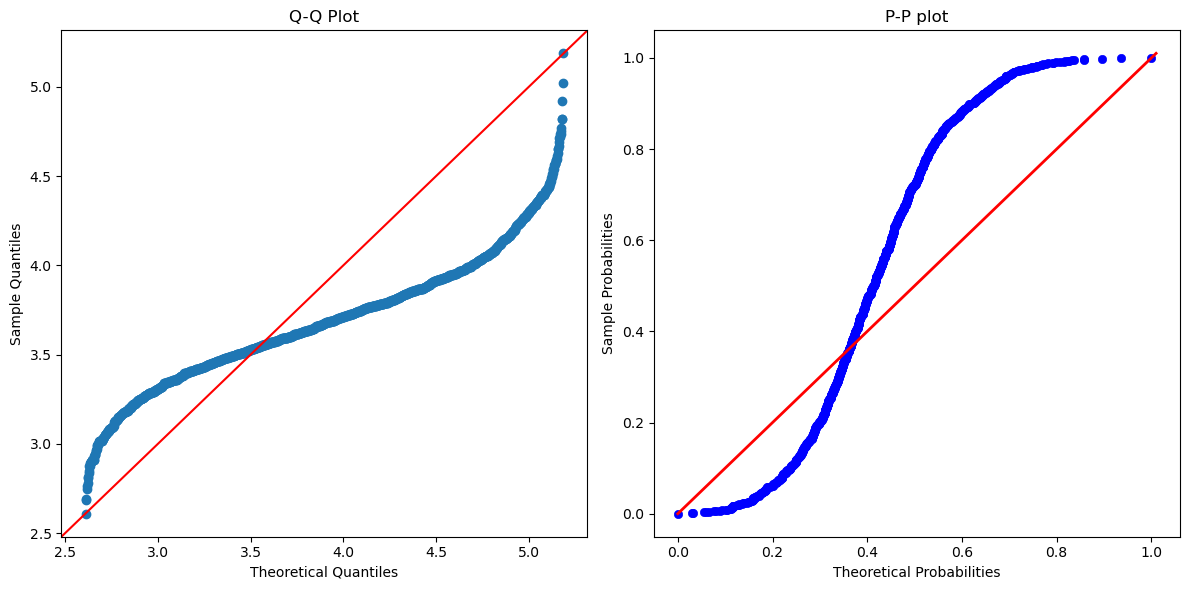

Análisis para la franja horaria UNIFORME: 3:00 pm - 9:00 pm
Parámetro estimado: a = 0.017816666666666665
Parámetro estimado: b = 53.4105


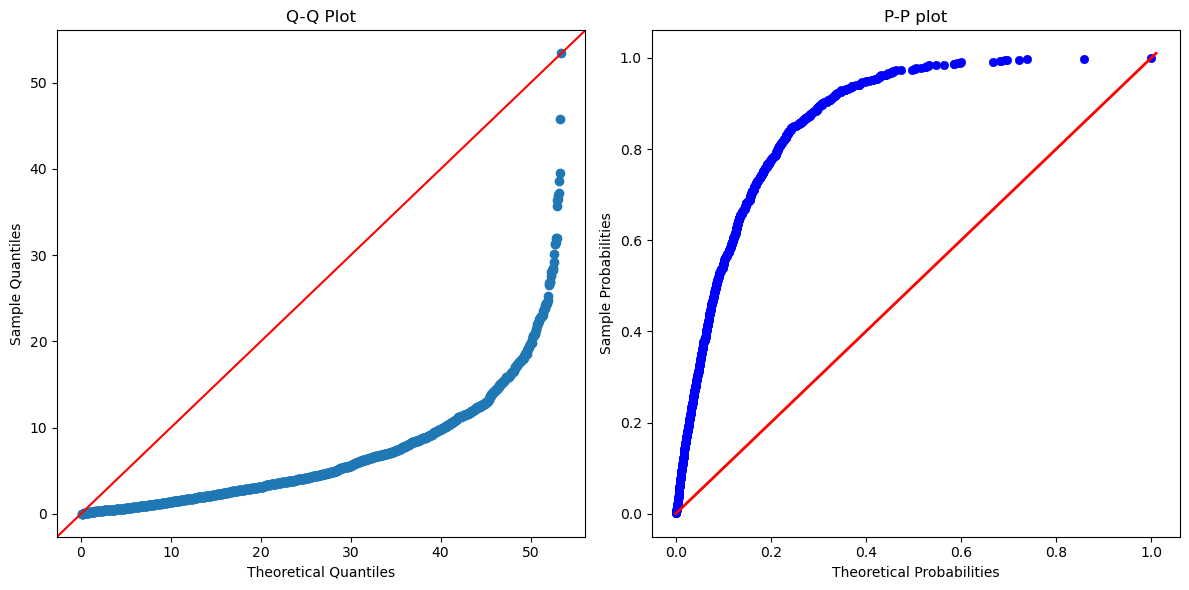

Análisis para la franja horaria UNIFORME: 9:00 pm - 6:00 am
Parámetro estimado: a = 7.010233333333333
Parámetro estimado: b = 14.998333333333333


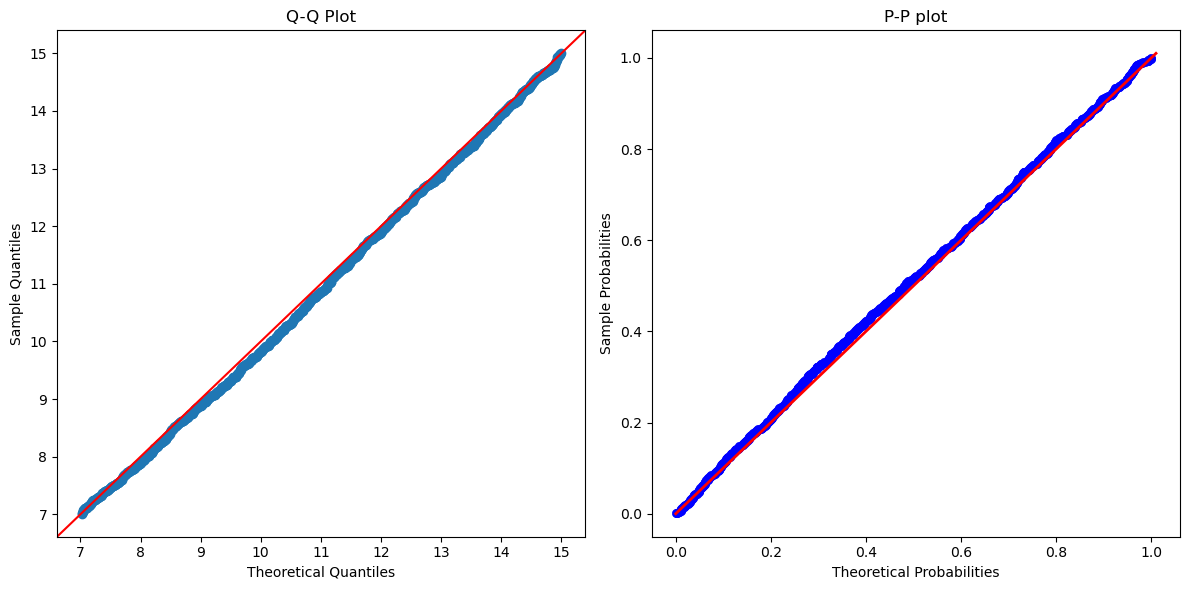

In [ ]:
for franja in franjas:
    print(f"Análisis para la franja horaria UNIFORME: {franja}")
    datos_franja = tiempos_entre_arribos_df[tiempos_entre_arribos_df['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    PP_QQ_plot_uniform(tiempos_entre_arribos)